https://www.kaggle.com/code/houssemayed/camembert-for-french-tweets-classification/notebook

https://www.techentice.com/how-to-make-jupyter-notebook-to-run-on-gpu/

# Setting up packages and data

### Installing useful packages

In [1]:
!pip install transformers
!pip install keras
!pip install tensorflow
!pip install sentencepiece
!pip install datasets

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 22.5 MB/s 
     |████████████████████████████████| 6.6 MB 22.5 MB/s 
     |████████████████████████████████| 596 kB 40.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 462 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 325 kB 4.1 MB/s 
     |████████████████████████████████| 136 kB 45.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.6 MB/s 
     |████████████████████████████████| 212 kB 54.1 MB/s 
     |████████████████████████████████| 127 kB 30.5 MB/s 
     |████████████████████████████████| 144 kB 50.5 MB/s 
     |████████████████████████████████| 271 kB 50.3 MB/s 
     |████████████████████████████████| 94 kB

### Importing useful packages

In [2]:
import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

### Dowloading useful data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_train = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='train_dataset.csv')
dataset_val = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='val_dataset.csv')

df_train = pd.DataFrame(dataset_train['train'])
df_val = pd.DataFrame(dataset_val['train'])

Using custom data configuration oscarfossey--NLP_Pole_emploi-c0261a038d48936e


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-c0261a038d48936e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-68372c9a27ced334


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-68372c9a27ced334/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.head(5)

,textual description,code_rome,categorie,sub_categorie,sub_sub_categorie,name,text_length
0,Nous recherchons pour le compte de notre clien...,I1305,I,13,5,Installation et maintenance électronique,304
1,Vous aurez en charge de superviser une équipe ...,N3103,N,31,3,Navigation fluviale,3214
2,L'Association des PEP 71 Recrute pour l'IME Or...,K1305,K,13,5,Intervention sociale et familiale,3124
3,CONTRAT DE FORMATION EN ALTERNANCE Groupe Alte...,G1302,G,13,2,Optimisation de produits touristiques,1559
4,"Trajectoires Conseils et Carrières, cabinet de...",H2505,H,25,5,Encadrement d'équipe ou d'atelier en matériaux...,1294


In [ ]:
df_train['text_#token'] = df_train['textual description'].apply(lambda text : len(text.split()))

# Fine-tunning the camemBert model to do classification

### Preprocessing data for camemebert

Mean number of token :  197.7711956521739


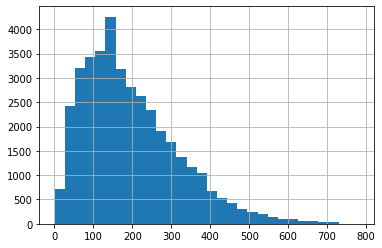

In [ ]:
print("Mean number of token : ", df_train['text_#token'].mean())
df_train["text_#token"].hist(bins = 30)

**Looking at the distribution of the lenght of the text we will pick a MAX_LEN of 200 for our inputs.**

In [5]:
epochs = 3
MAX_LEN = 200
batch_size = 8

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if DEVICE.type != 'cpu':
  print(torch.cuda.get_device_name(DEVICE))

Tesla K80


In [6]:
print(torch.cuda.get_device_name(DEVICE))

Tesla T4


In [6]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [7]:
# Creates list of texts and categories for train and validation split
text_train = df_train['textual description'].to_list()
text_val = df_val['textual description'].to_list()

#OneHotencoding our categories 
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

categories_train = categorical_encoder.fit_transform(df_train[['categorie']]).toarray()
categories_val = categorical_encoder.transform(df_val[['categorie']]).toarray()

# Using the Camemebert Tokenizer 
input_ids_train  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN,truncation=True) for sent in text_train]
input_ids_val  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN,truncation=True) for sent in text_val]

# Pad our input tokens
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks_train = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_train:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks_train.append(seq_mask)

attention_masks_val = []
for seq in input_ids_val:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks_val.append(seq_mask)

In [8]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_val)
train_categories = torch.from_numpy(categories_train)
validation_categories = torch.from_numpy(categories_val)
train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_val)

In [9]:
train_data = TensorDataset(train_inputs, train_masks, train_categories)

## Creating a random balanced sampling method & random sampling method for the tranning data

train_categories_labels = categorical_encoder.inverse_transform(train_categories)

class_sample_count = np.array([len(np.where( train_categories_labels == t)[0]) for t in np.unique(train_categories_labels)])
weight = 1. / class_sample_count
get_idx = {}
for i, label in enumerate(np.unique(train_categories_labels)):
  get_idx[label] = i
samples_weight = np.array([weight[get_idx[t[0]]] for t in train_categories_labels])
samples_weight = torch.from_numpy(samples_weight)

train_weighted_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_random_sampler = RandomSampler(train_data)

## Creating the dataloaders

train_dataloader_balanced = DataLoader(train_data, sampler=train_weighted_sampler, batch_size=batch_size)
train_dataloader_unbalanced = DataLoader(train_data, sampler=train_random_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_categories)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Blue : balanced dataset 
Orange : unbalanced dataset


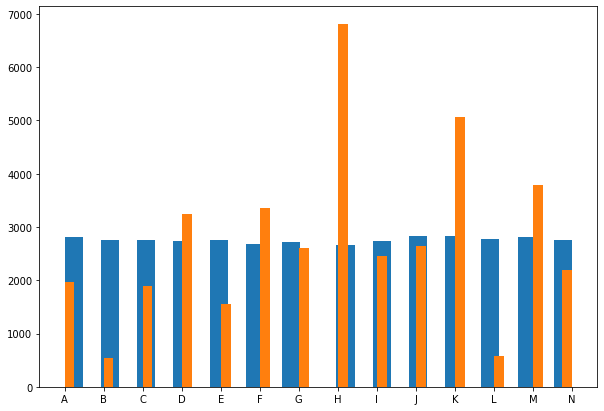

In [ ]:
y_train_over = []
for batch , masks, labels in train_dataloader_balanced:
  for label in labels:
    #print(np.array([np.array(label)]))
    y_train_over.append(categorical_encoder.inverse_transform(np.array([np.array(label)])))

y_train_over = np.array(y_train_over)
pd.DataFrame(y_train_over[:,:,0]).sort_values(0)[0].hist(bins = 28, grid = False, figsize = (10,7))
pd.DataFrame(train_categories_labels).sort_values(0)[0].hist(bins = 52, grid = False, figsize = (10,7))
print("Blue : balanced dataset \nOrange : unbalanced dataset")


### Tools to train the model

In [10]:
class deepmodel:
  """Class desgined to work with torch ML models. 
  This class is useful to train a model on differents runtime sessions"""

  def __init__(self,lemodel = None, lepath = None, letrain_dataloader = None,
               leval_dataloader = None, letest_dataloader = None, letrainning_data_path = None
               , le_lr=2e-5, le_eps=10e-8):
      self.model = lemodel
      self.path = lepath
      self.dataloaders = {"train_dataloader" : letrain_dataloader , "val_dataloader" : leval_dataloader, "test_dataloader" : letest_dataloader}
      self.trainning_data_path = letrainning_data_path
      if self.trainning_data_path == None:
        self.training_data = {"Total_epoch_trained" : 0, "Total_batch_trainned" : 0, "Current_batch_trainned" : 0, "Loss_evolution" : [], "accuracy_evolution" : []}
      if self.trainning_data_path != None:
        self.load_trainning_data()
      self.optimizer = self.define_optimizer(le_lr, le_eps)

  def save_model(self):
    torch.save(self.model.state_dict(), self.path)

  def load_model(self):
    self.model.load_state_dict(torch.load(self.path))

  def save_training_data(self):
    pickle.dump(self.trainning_data, open(self.trainning_data_path, "wb"))

  def load_trainning_data(self):
    self.trainning_data = pickle.load(open(self.trainning_data_path, "rb"))

  def define_optimizer(self, le_lr, le_eps):
    param_optimizer = list(self.model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
                                    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                      'weight_decay_rate': 0.01},
                                    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                    'weight_decay_rate': 0.0}
                                    ]

    return AdamW(optimizer_grouped_parameters, lr = le_lr, eps = le_eps)




In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def train_one_batch(lemodel):
    lemodel.model.train()
    step = lemodel.trainning_data['Current_batch_trainned']
    for i, bat in enumerate(lemodel.dataloaders["train_dataloader"]):
      if i == step:
        batch = bat   #Selecting the right batch
        break

    # Add batch to device CPU or GPU
    if DEVICE.type != 'cpu':
      batch = tuple(t.to(DEVICE) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    lemodel.optimizer.zero_grad()
    # Forward pass
    outputs = lemodel.model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # Get loss value
    loss = outputs[0]
    # Add it to train loss list
    lemodel.trainning_data['Loss_evolution'].append(loss.item())  
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    lemodel.optimizer.step()
      
    # Update tracking variables
    lemodel.trainning_data['Total_batch_trainned'] += 1
    lemodel.trainning_data['Total_epoch_trainned'] = lemodel.trainning_data['Total_batch_trainned']/len(lemodel.dataloaders["train_dataloader"])
    step = (step + 1)%len(lemodel.dataloaders["train_dataloader"])
    lemodel.trainning_data['Current_batch_trainned'] = step



In [ ]:
def get_validation_score(lemodel, save = False):
  
  lemodel.model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in lemodel.dataloaders["val_dataloader"]:
        # Add batch to device CPU or GPU
        if DEVICE.type != 'cpu':
          batch = tuple(t.to(DEVICE) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  lemodel.model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        if DEVICE.type != 'cpu':
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
  if save: 
    lemodel.trainning_data['accuracy_evolution'].append(eval_accuracy/nb_eval_steps)
  print("Validation Accuracy for {}: {}".format(eval_accuracy/nb_eval_steps, lemodel.trainning_data["Total_batch_trainned"]))



In [11]:
get_label = {}
for i, label in enumerate(np.unique(train_categories_labels)):
  get_label[i] = label

def predict(lemodel, inputs, masks, step = 100):
  "Predicting the outputs step by step trough all the inputs"
  
  lemodel.model.eval()
  predictions = []
  i = 0
  while i < len(inputs) :
    pred = []      
    if DEVICE.type != 'cpu':
      local_inputs = inputs[i:min(i + step, len(inputs))].to(DEVICE)
      local_masks = masks[i:min(i + step, len(masks))].to(DEVICE)    
    else: 
      local_inputs = inputs[i:min(i + step, len(inputs))]
      local_masks = masks[i:min(i + step, len(masks))]
    with torch.no_grad():
      outputs =  lemodel.model(local_inputs, token_type_ids = None, attention_mask = local_masks)
      logits = outputs[0]
    if DEVICE.type != 'cpu':
      logits = logits.detach().cpu().numpy()
    pred.extend(np.argmax(logits, axis=1).flatten())
    pred = [get_label[int(i)] for i in pred]
    predictions.extend(pred)
    i = min(i + step, len(inputs))
      
    

  return predictions

#< >

In [ ]:
def train(model, number_of_batch_to_train, validation_every = 500):

  for i in tqdm(range(number_of_batch_to_train)):
    train_one_batch(model)
    if model.trainning_data["Total_batch_trainned"]%validation_every == 0:
      get_validation_score(model, save = True)
      model.save_model()
      model.save_training_data()
  get_validation_score(model)
  model.save_model()
  model.save_training_data()
  


### Unbalanced dataset trainning

We will trainned our model batch by batch and frequently save them in a folder to keep track of the progression across many session of google colab.

In [ ]:
#Defining folder path 

trainning_data_path_name = "trainning_data_unbalancedv2.pth"
trainning_data_path_unbalancedv2 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{trainning_data_path_name}" 
model_save_name = 'model_camembert_unbalancedv2.pth'
model_path_unbalancedv2 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{model_save_name}"

#Initialisation of the model

clf_model_unbalancedv2 = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=14) #for our 14 categories A to N
if DEVICE.type != 'cpu':
  clf_model_unbalancedv2.to(DEVICE)

try: # the model as already been saved once
    clf_model_unbalancedv2.load_state_dict(torch.load(model_path_unbalancedv2))
except: # initialisation of the files for the models
    pickle.dump({"Total_epoch_trained" : 0, "Total_batch_trainned" : 0, "Current_batch_trainned" : 0, "Loss_evolution" : [], "accuracy_evolution" : []}
                , open(trainning_data_path_unbalancedv2, "wb"))

MODEL_unbalancedv2 = deepmodel(lemodel = clf_model_unbalancedv2, lepath = model_path_unbalancedv2, letrain_dataloader = train_dataloader_unbalanced,
                            leval_dataloader = validation_dataloader, letrainning_data_path = trainning_data_path_unbalancedv2)

MODEL_unbalancedv2.save_model()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [ ]:
train(model = MODEL_unbalancedv2, number_of_batch_to_train = 2000)

 25%|██▍       | 499/2000 [04:57<15:35,  1.60it/s]

Validation Accuracy for 0.18668528864059591: 500


 50%|████▉     | 999/2000 [15:57<11:38,  1.43it/s]

Validation Accuracy for 0.49875853507138423: 1000


 75%|███████▍  | 1499/2000 [27:31<06:20,  1.32it/s]

Validation Accuracy for 0.6391992551210428: 1500


100%|█████████▉| 1999/2000 [39:39<00:00,  1.21it/s]

Validation Accuracy for 0.6660459342023588: 2000


100%|██████████| 2000/2000 [45:10<00:00,  1.36s/it]


Validation Accuracy for 0.6660459342023588: 2000


In [ ]:
train(model = MODEL_unbalancedv2, number_of_batch_to_train = 2000)

 25%|██▍       | 499/2000 [07:13<22:40,  1.10it/s]

Validation Accuracy for 0.6838919925512105: 2500


 50%|████▉     | 999/2000 [20:36<16:05,  1.04it/s]

Validation Accuracy for 0.7048417132216015: 3000


 75%|███████▍  | 1499/2000 [34:31<08:46,  1.05s/it]

Validation Accuracy for 0.694056486654252: 3500


100%|█████████▉| 1999/2000 [49:02<00:01,  1.12s/it]

Validation Accuracy for 0.7197392923649907: 4000


100%|██████████| 2000/2000 [54:32<00:00,  1.64s/it]


Validation Accuracy for 0.7197392923649907: 4000


In [ ]:
train(model = MODEL_unbalancedv2, number_of_batch_to_train = 2000)

 25%|██▍       | 499/2000 [09:32<29:37,  1.18s/it]

Validation Accuracy for 0.7276536312849162: 4500


 50%|████▉     | 999/2000 [23:22<09:47,  1.70it/s]

Validation Accuracy for 0.7297486033519553: 5000


 75%|███████▍  | 1499/2000 [33:59<05:30,  1.51it/s]

Validation Accuracy for 0.7323867163252639: 5500


100%|█████████▉| 1999/2000 [45:13<00:00,  1.39it/s]

Validation Accuracy for 0.7450341402855369: 6000


100%|██████████| 2000/2000 [50:43<00:00,  1.52s/it]


Validation Accuracy for 0.7450341402855369: 6000


In [ ]:
train(model = MODEL_unbalancedv2, number_of_batch_to_train = 4000, validation_every = 1500)

 37%|███▋      | 1499/4000 [11:24<21:47,  1.91it/s]

Validation Accuracy for 0.747284295468653: 7500


 75%|███████▍  | 2999/4000 [29:05<11:10,  1.49it/s]

Validation Accuracy for 0.7471291123525761: 9000


100%|██████████| 4000/4000 [41:24<00:00,  1.61it/s]


Validation Accuracy for 0.7530260707635009: 10000


In [ ]:
train(model = MODEL_unbalancedv2, number_of_batch_to_train = 2000, validation_every = 1500)

 25%|██▍       | 499/2000 [02:51<09:15,  2.70it/s]

Validation Accuracy for 0.7524053382991931: 10500


100%|█████████▉| 1999/2000 [16:31<00:00,  2.00it/s]

Validation Accuracy for 0.755276225946617: 12000


100%|██████████| 2000/2000 [19:19<00:00,  1.72it/s]


Validation Accuracy for 0.755276225946617: 12000


**Training summary**

In [ ]:
#number of epoch trainned
print("Total epoch trained : ", MODEL_unbalancedv2.trainning_data["Total_batch_trainned"]/len(MODEL_unbalancedv2.dataloaders["train_dataloader"]))

Total epoch trained :  2.484472049689441


Text(0.5, 0, 'batch ')

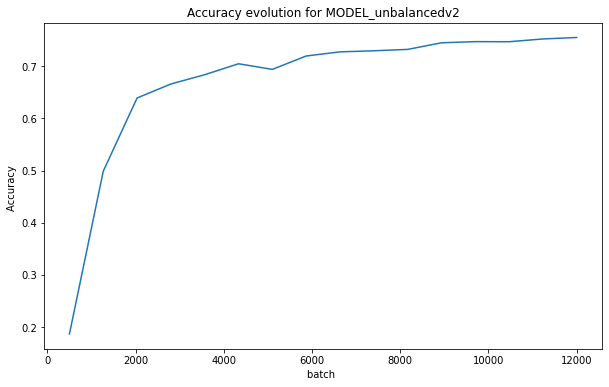

In [ ]:
#accuracy evolution

batch_evolution = np.linspace(500,12000, len(MODEL_unbalancedv2.trainning_data["accuracy_evolution"]))
plt.figure(figsize=(10, 6))
plt.plot(batch_evolution, MODEL_unbalancedv2.trainning_data["accuracy_evolution"])
plt.title('Accuracy evolution for MODEL_unbalancedv2')
plt.ylabel('Accuracy ')
plt.xlabel('batch ')

Text(0.5, 0, 'batch ')

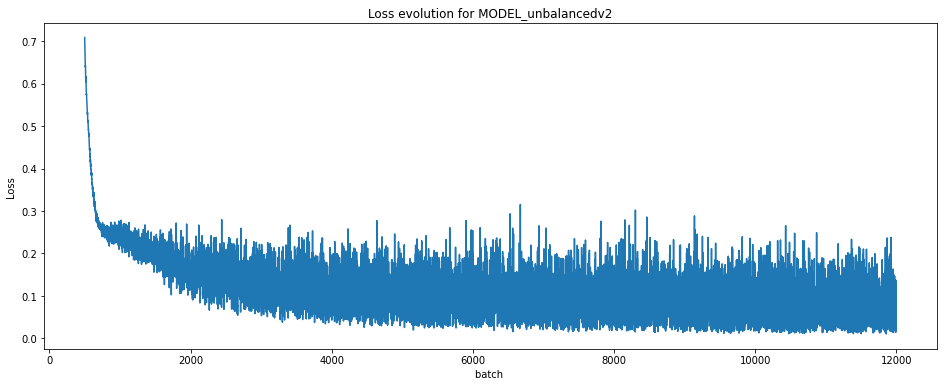

In [ ]:
#loss evolution

batch_evolution = np.linspace(500,12000, len(MODEL_unbalancedv2.trainning_data["Loss_evolution"]))
plt.figure(figsize=(16, 6))
plt.plot(batch_evolution, MODEL_unbalancedv2.trainning_data["Loss_evolution"])
plt.title('Loss evolution for MODEL_unbalancedv2')
plt.ylabel('Loss ')
plt.xlabel('batch ')


## Balanced dataset trainnig

We will trainned our model batch by batch and frequently save them in a folder to keep track of the progression across many session of google colab.

In [ ]:
#Defining folder path 

trainning_data_path_name = "trainning_data_balancedv1.pth"
trainning_data_path_balancedv1 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{trainning_data_path_name}" 
model_save_name = 'model_camembert_balancedv1.pth'
model_path_balancedv1 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{model_save_name}"

#Initialisation of the model

clf_model_balancedv1 = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=14) #for our 14 categories A to N
if DEVICE.type != 'cpu':
  clf_model_balancedv1.to(DEVICE)

try: # the model as already been saved once
    clf_model_balancedv1.load_state_dict(torch.load(model_path_balancedv1))
except: # initialisation of the files for the models
    pickle.dump({"Total_epoch_trained" : 0, "Total_batch_trainned" : 0, "Current_batch_trainned" : 0, "Loss_evolution" : [], "accuracy_evolution" : []}
                , open(trainning_data_path_balancedv1, "wb"))

MODEL_balancedv1 = deepmodel(lemodel = clf_model_balancedv1, lepath = model_path_balancedv1, letrain_dataloader = train_dataloader_balanced,
                            leval_dataloader = validation_dataloader, letrainning_data_path = trainning_data_path_balancedv1)

MODEL_balancedv1.save_model()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [ ]:
train(model = MODEL_balancedv1, number_of_batch_to_train = 2250)

 22%|██▏       | 499/2250 [04:57<18:22,  1.59it/s]

Validation Accuracy for 0.05408131595282433: 500


 44%|████▍     | 999/2250 [16:01<14:37,  1.43it/s]

Validation Accuracy for 0.5145096213531968: 1000


 67%|██████▋   | 1499/2250 [27:39<09:34,  1.31it/s]

Validation Accuracy for 0.6142147734326505: 1500


 89%|████████▉ | 1999/2250 [39:52<03:32,  1.18it/s]

Validation Accuracy for 0.6637957790192427: 2000


100%|██████████| 2250/2250 [48:58<00:00,  1.31s/it]


Validation Accuracy for 0.6395096213531968: 2250


In [ ]:
train(model = MODEL_balancedv1, number_of_batch_to_train = 2250)

 11%|█         | 249/2250 [03:43<30:36,  1.09it/s]

Validation Accuracy for 0.6621663563004345: 2500


 33%|███▎      | 749/2250 [17:01<23:59,  1.04it/s]

Validation Accuracy for 0.6895561762880199: 3000


 56%|█████▌    | 1249/2250 [30:55<17:02,  1.02s/it]

Validation Accuracy for 0.6990999379267536: 3500


 78%|███████▊  | 1749/2250 [45:19<09:07,  1.09s/it]

Validation Accuracy for 0.7042985723153321: 4000


100%|█████████▉| 2249/2250 [1:00:16<00:01,  1.17s/it]

Validation Accuracy for 0.6950651769087524: 4500


100%|██████████| 2250/2250 [1:05:47<00:00,  1.75s/it]


Validation Accuracy for 0.6950651769087524: 4500


In [ ]:
train(model = MODEL_balancedv1, number_of_batch_to_train = 2250)

 22%|██▏       | 499/2250 [08:17<17:09,  1.70it/s]

Validation Accuracy for 0.723308504034761: 5000


 44%|████▍     | 999/2250 [18:57<13:36,  1.53it/s]

Validation Accuracy for 0.7186530105524519: 5500


 67%|██████▋   | 1499/2250 [30:12<09:08,  1.37it/s]

Validation Accuracy for 0.7178770949720671: 6000


 89%|████████▉ | 1999/2250 [42:02<03:19,  1.26it/s]

Validation Accuracy for 0.721058348851645: 6500


100%|██████████| 2250/2250 [50:56<00:00,  1.36s/it]


Validation Accuracy for 0.7293606455617628: 6750


In [ ]:
train(model = MODEL_balancedv1, number_of_batch_to_train = 2250)

 11%|█         | 249/2250 [03:30<28:44,  1.16it/s]

Validation Accuracy for 0.728739913097455: 7000


 33%|███▎      | 749/2250 [16:30<23:25,  1.07it/s]

Validation Accuracy for 0.7302917442582247: 7500


 56%|█████▌    | 1249/2250 [30:04<16:47,  1.01s/it]

Validation Accuracy for 0.7291278708876474: 8000


 78%|███████▊  | 1749/2250 [44:11<08:55,  1.07s/it]

In [ ]:
train(model = MODEL_balancedv1, number_of_batch_to_train = 4000, validation_every = 1500)

 25%|██▍       | 999/4000 [10:24<33:32,  1.49it/s]

Validation Accuracy for 0.7281967721911856: 9000


 62%|██████▏   | 2499/4000 [26:11<09:19,  2.68it/s]

Validation Accuracy for 0.723618870266915: 10500


100%|█████████▉| 3999/4000 [39:58<00:00,  1.99it/s]

Validation Accuracy for 0.7219894475481068: 12000


100%|██████████| 4000/4000 [42:46<00:00,  1.56it/s]


Validation Accuracy for 0.7219894475481068: 12000


**Training summary**

In [ ]:
#number of epoch trainned
print("Total epoch trained : ", MODEL_balancedv1.trainning_data["Total_batch_trainned"]/len(MODEL_balancedv1.dataloaders["train_dataloader"]))

Total epoch trained :  2.484472049689441


Text(0.5, 0, 'batch ')

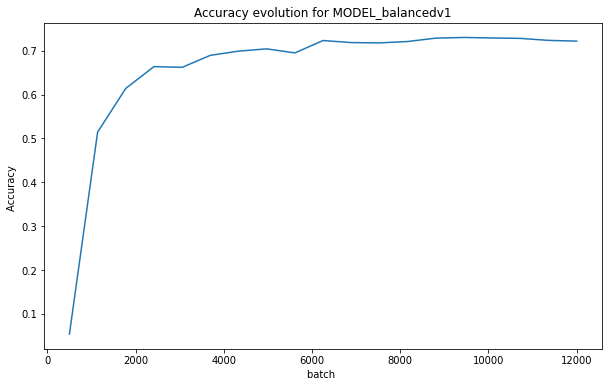

In [ ]:
#accuracy evolution
batch_evolution = np.linspace(500,12000, len(MODEL_balancedv1.trainning_data["accuracy_evolution"]))
plt.figure(figsize=(10, 6))
plt.plot(batch_evolution, MODEL_balancedv1.trainning_data["accuracy_evolution"])
plt.title('Accuracy evolution for MODEL_balancedv1')
plt.ylabel('Accuracy ')
plt.xlabel('batch ')

Text(0.5, 0, 'batch ')

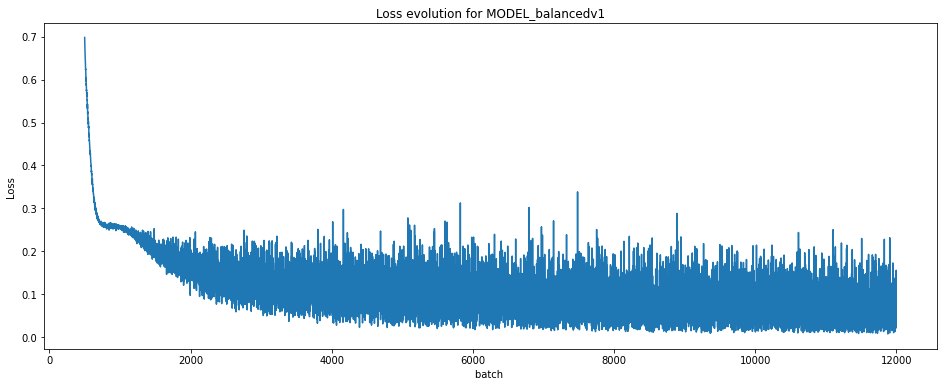

In [ ]:
#loss evolution
batch_evolution = np.linspace(500,12000, len(MODEL_balancedv1.trainning_data["Loss_evolution"]))
plt.figure(figsize=(16, 6))
plt.plot(batch_evolution, MODEL_balancedv1.trainning_data["Loss_evolution"])
plt.title('Loss evolution for MODEL_balancedv1')
plt.ylabel('Loss ')
plt.xlabel('batch ')

# Analyzing performances on the validation dataset (Accuracy & confusion matrix)

**Reloading the model from an other session (the trainning session)**

In [22]:
#Defining folder path 

trainning_data_path_name = "trainning_data_unbalancedv2.pth"
trainning_data_path_unbalancedv2 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{trainning_data_path_name}" 
model_save_name = 'model_camembert_unbalancedv2.pth'
model_path_unbalancedv2 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{model_save_name}"

#Initialisation of the model

clf_model_unbalancedv2 = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=14) #for our 14 categories A to N

if DEVICE.type != 'cpu':
  clf_model_unbalancedv2.to(DEVICE)

try: # the model as already been saved once
    clf_model_unbalancedv2.load_state_dict(torch.load(model_path_unbalancedv2))
except: # initialisation of the files for the models
    pickle.dump({"Total_epoch_trained" : 0, "Total_batch_trainned" : 0, "Current_batch_trainned" : 0, "Loss_evolution" : [], "accuracy_evolution" : []}
                , open(trainning_data_path_unbalancedv2, "wb"))

MODEL_unbalancedv2 = deepmodel(lemodel = clf_model_unbalancedv2, lepath = model_path_unbalancedv2, letrain_dataloader = train_dataloader_unbalanced,
                            leval_dataloader = validation_dataloader, letrainning_data_path = trainning_data_path_unbalancedv2)

MODEL_unbalancedv2.save_model()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

### Testing model trained on an unbalanced data

In [23]:
#draw prediction for the unbalanced model
val_predictions_unbalanced = predict(MODEL_unbalancedv2, validation_inputs, validation_masks)

labels  = []
labels.extend(np.argmax(validation_categories, axis=1).flatten())
labels = [get_label[int(i)] for i in labels]

In [24]:
print(metrics.classification_report(labels, val_predictions_unbalanced, target_names=list(df_val.sort_values("categorie")["categorie"].unique())))

              precision    recall  f1-score   support

           A       0.82      0.74      0.78       680
           B       0.81      0.47      0.59       185
           C       0.73      0.73      0.73       619
           D       0.78      0.80      0.79      1046
           E       0.74      0.53      0.62       489
           F       0.79      0.77      0.78      1054
           G       0.86      0.77      0.81       863
           H       0.72      0.82      0.77      2324
           I       0.67      0.70      0.69       810
           J       0.92      0.87      0.90       910
           K       0.77      0.77      0.77      1718
           L       0.87      0.50      0.63       198
           M       0.64      0.68      0.66      1257
           N       0.71      0.78      0.74       728

    accuracy                           0.76     12881
   macro avg       0.77      0.71      0.73     12881
weighted avg       0.76      0.76      0.75     12881



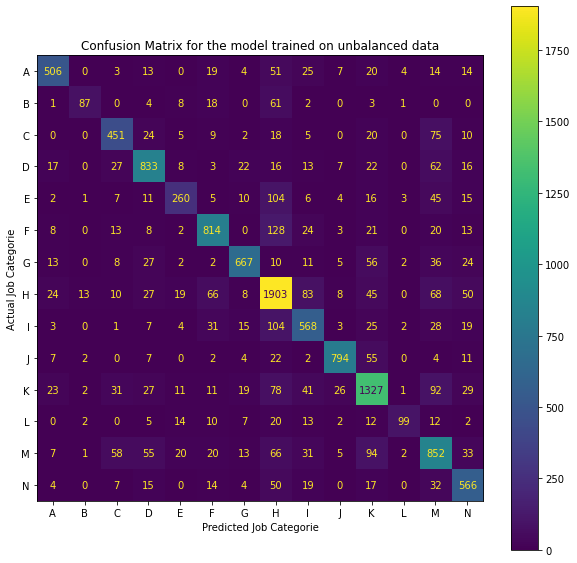

In [25]:
cm_unbalanced = confusion_matrix(labels, val_predictions_unbalanced, labels = list(df_val.sort_values("categorie")["categorie"].unique()))

cmd_obj_unbalanced = ConfusionMatrixDisplay(cm_unbalanced, display_labels=list(df_val.sort_values("categorie")["categorie"].unique()))
cmd_obj_unbalanced.plot()
cmd_obj_unbalanced.ax_.set(title='Confusion Matrix for the model trained on unbalanced data', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

### Testing model trained on a balanced dataset

In [12]:
#Defining folder path 

trainning_data_path_name = "trainning_data_balancedv1.pth"
trainning_data_path_balancedv1 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{trainning_data_path_name}" 
model_save_name = 'model_camembert_balancedv1.pth'
model_path_balancedv1 = F"/content/drive/MyDrive/Cours/ENSAE/NLP/Projet/{model_save_name}"

#Initialisation of the model

clf_model_balancedv1 = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=14) #for our 14 categories A to N
if DEVICE.type != 'cpu':
  clf_model_balancedv1.to(DEVICE)

try: # the model as already been saved once
    clf_model_balancedv1.load_state_dict(torch.load(model_path_balancedv1))
except: # initialisation of the files for the models
    pickle.dump({"Total_epoch_trained" : 0, "Total_batch_trainned" : 0, "Current_batch_trainned" : 0, "Loss_evolution" : [], "accuracy_evolution" : []}
                , open(trainning_data_path_balancedv1, "wb"))

MODEL_balancedv1 = deepmodel(lemodel = clf_model_balancedv1, lepath = model_path_balancedv1, letrain_dataloader = train_dataloader_balanced,
                            leval_dataloader = validation_dataloader, letrainning_data_path = trainning_data_path_balancedv1)

MODEL_balancedv1.save_model()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

In [13]:
#draw prediction for the balanced model
val_predictions_balanced = predict(MODEL_balancedv1, validation_inputs, validation_masks)

In [15]:
labels  = []
labels.extend(np.argmax(validation_categories, axis=1).flatten())
labels = [get_label[int(i)] for i in labels]

In [16]:
print(metrics.classification_report(labels, val_predictions_balanced, target_names=list(df_val.sort_values("categorie")["categorie"].unique())))

              precision    recall  f1-score   support

           A       0.76      0.76      0.76       680
           B       0.57      0.71      0.63       185
           C       0.74      0.71      0.72       619
           D       0.76      0.78      0.77      1046
           E       0.50      0.64      0.56       489
           F       0.79      0.77      0.78      1054
           G       0.79      0.82      0.80       863
           H       0.81      0.58      0.68      2324
           I       0.61      0.73      0.67       810
           J       0.84      0.91      0.88       910
           K       0.79      0.72      0.75      1718
           L       0.37      0.65      0.47       198
           M       0.61      0.68      0.64      1257
           N       0.70      0.77      0.73       728

    accuracy                           0.72     12881
   macro avg       0.69      0.73      0.70     12881
weighted avg       0.74      0.72      0.72     12881



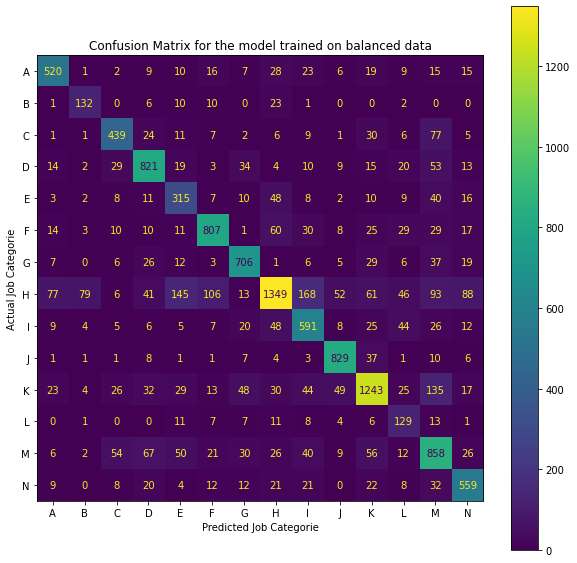

In [20]:
cm_balanced = confusion_matrix(labels, val_predictions_balanced, labels = list(df_val.sort_values("categorie")["categorie"].unique()))

cmd_obj_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels=list(df_val.sort_values("categorie")["categorie"].unique()))
cmd_obj_balanced.plot()
cmd_obj_balanced.ax_.set(title='Confusion Matrix for the model trained on balanced data', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

# Conclusion

We've fine tuned the camemebert model for classification on two differents training datasets : 

- No sampling technics : 76 % accuracy on the val dataset

- Random weigth sampling technics : 72 % accuracy on the val dataset